### https://captum.ai/tutorials/Multimodal_VQA_Interpret

In [1]:
!python --version

Python 3.8.12


In [2]:
import os, sys

# Replace <PROJECT-DIR> placeholder with your project directory path
PROJECT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

# Clone PyTorch VQA project from: https://github.com/Cyanogenoid/pytorch-vqa and add to your filepath
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/pytorch-vqa"))

# Clone PyTorch Resnet model from: https://github.com/Cyanogenoid/pytorch-resnet and add to your filepath
# We can also use standard resnet model from torchvision package, however the model from `pytorch-resnet` 
# is slightly different from the original resnet model and performs better on this particular VQA task
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/pytorch-resnet"))

In [6]:
import threading
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from pytorch_resnet import resnet  # from pytorch-resnet

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

from pytorch_vqa.model import Net, apply_attention, tile_2d_over_nd # from pytorch-vqa
from pytorch_vqa.utils import get_transform # from pytorch-vqa

from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    TokenReferenceBase,
    configure_interpretable_embedding_layer,
    remove_interpretable_embedding_layer,
    visualization
)
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
saved_state = torch.load('models/2017-08-04_00.55.19.pth', map_location=device)

# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx] = w

In [9]:
vqa_net = torch.nn.DataParallel(Net(num_tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

In [10]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [11]:
class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True)
        self.r_model.eval()
        self.r_model.to(device)

        self.buffer = {}
        lock = threading.Lock()

        # Since we only use the output of the 4th layer from the resnet model and do not
        # need to do forward pass all the way to the final layer we can terminate forward
        # execution in the forward hook of that layer after obtaining the output of it.
        # For that reason, we can define a custom Exception class that will be used for
        # raising early termination error.
        def save_output(module, input, output):
            with lock:
                self.buffer[output.device] = output

        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.r_model(x)          
        return self.buffer[x.device]

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()
    
    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = self.resnet_layer4(v)

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer

In [12]:
USE_INTEPRETABLE_EMBEDDING_LAYER = False  # set to True for option (1)

In [13]:
vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)

# wrap the inputs into layers incase we wish to use a layer method
vqa_resnet = ModelInputWrapper(vqa_resnet)

# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet)

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.module.state_dict()
state.update(partial_dict)
vqa_resnet.module.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net

In [14]:
if USE_INTEPRETABLE_EMBEDDING_LAYER:
    interpretable_embedding = configure_interpretable_embedding_layer(vqa_resnet, 'module.module.text.embedding')

In [16]:
image_size = 100  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
    
def image_to_features(img):
    img_transformed = transform(img)
    img_batch = img_transformed.unsqueeze(0).to(device)
    return img_batch

In [17]:
PAD_IND = token_to_index['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [18]:
# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled=False

In [20]:
if USE_INTEPRETABLE_EMBEDDING_LAYER:
    attr = IntegratedGradients(vqa_resnet)
else:
    attr = LayerIntegratedGradients(vqa_resnet, [vqa_resnet.module.input_maps["v"], vqa_resnet.module.module.text.embedding])

In [21]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)

In [22]:
def vqa_resnet_interpret(image_filename, questions, targets):
    img = Image.open(image_filename).convert('RGB')
    original_image = transforms.Compose([transforms.Scale(int(image_size / central_fraction)),
                                   transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    
    image_features = image_to_features(img).requires_grad_().to(device)
    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)
        
        # generate reference for each sample
        q_reference_indices = token_reference.generate_reference(q_len.item(), device=device).unsqueeze(0)

        inputs = (q.unsqueeze(0), q_len.unsqueeze(0))
        if USE_INTEPRETABLE_EMBEDDING_LAYER:
            q_input_embedding = interpretable_embedding.indices_to_embeddings(q).unsqueeze(0)
            q_reference_baseline = interpretable_embedding.indices_to_embeddings(q_reference_indices).to(device)

            inputs = (image_features, q_input_embedding)
            baselines = (image_features * 0.0, q_reference_baseline)
            
        else:            
            inputs = (image_features, q.unsqueeze(0))
            baselines = (image_features * 0.0, q_reference_indices)
            
        ans = vqa_resnet(*inputs, q_len.unsqueeze(0))
            
        # Make a prediction. The output of this prediction will be visualized later.
        pred, answer_idx = F.softmax(ans, dim=1).data.cpu().max(dim=1)

        attributions = attr.attribute(inputs=inputs,
                                    baselines=baselines,
                                    target=answer_idx,
                                    additional_forward_args=q_len.unsqueeze(0),
                                    n_steps=30)
            
        # Visualize text attributions
        text_attributions_norm = attributions[1].sum(dim=2).squeeze(0).norm()
        vis_data_records = [visualization.VisualizationDataRecord(
                                attributions[1].sum(dim=2).squeeze(0) / text_attributions_norm,
                                pred[0].item(),
                                answer_words[ answer_idx ],
                                answer_words[ answer_idx ],
                                target,
                                attributions[1].sum(),       
                                question.split(),
                                0.0)]
        visualization.visualize_text(vis_data_records)

        # visualize image attributions
        original_im_mat = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
        attributions_img = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
        
        visualization.visualize_image_attr_multiple(attributions_img, original_im_mat, 
                                                    ["original_image", "heat_map"], ["all", "absolute_value"], 
                                                    titles=["Original Image", "Attribution Magnitude"],
                                                    cmap=default_cmap,
                                                    show_colorbar=True)
        print('Text Contributions: ', attributions[1].sum().item())
        print('Image Contributions: ', attributions[0].sum().item())
        print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())

In [27]:
images = ['./img/vqa/siamese.jpg',
          './img/vqa/elephant.jpg',
          './img/vqa/zebra.jfif']

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
elephants,elephants (0.50),elephant,7.58,what is on the picture


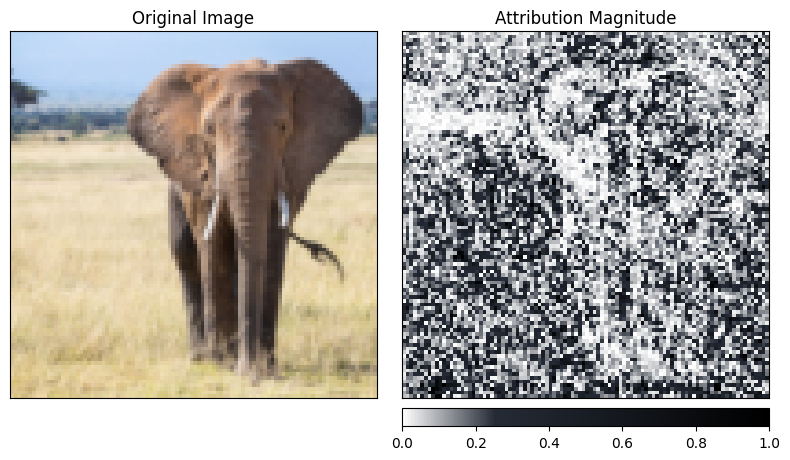

Text Contributions:  7.578137261577181
Image Contributions:  33.34300995337137
Total Contribution:  40.921147214948554


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
gray,gray (0.67),gray,7.10,what color is the elephant


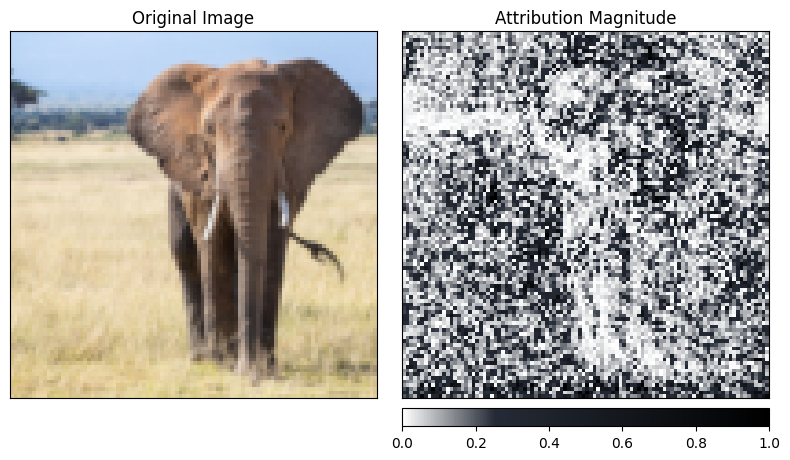

Text Contributions:  7.098944589862056
Image Contributions:  11.676718714302778
Total Contribution:  18.775663304164834


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
water,water (0.29),zoo,7.64,where is the elephant


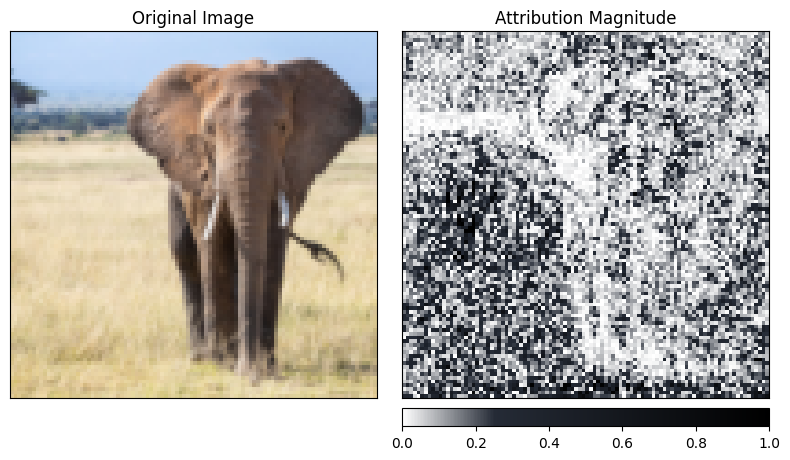

Text Contributions:  7.6415941563256276
Image Contributions:  14.462839159514008
Total Contribution:  22.104433315839636


In [24]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 1 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is the elephant",
    "where is the elephant"
], ['elephant', 'gray', 'zoo'])

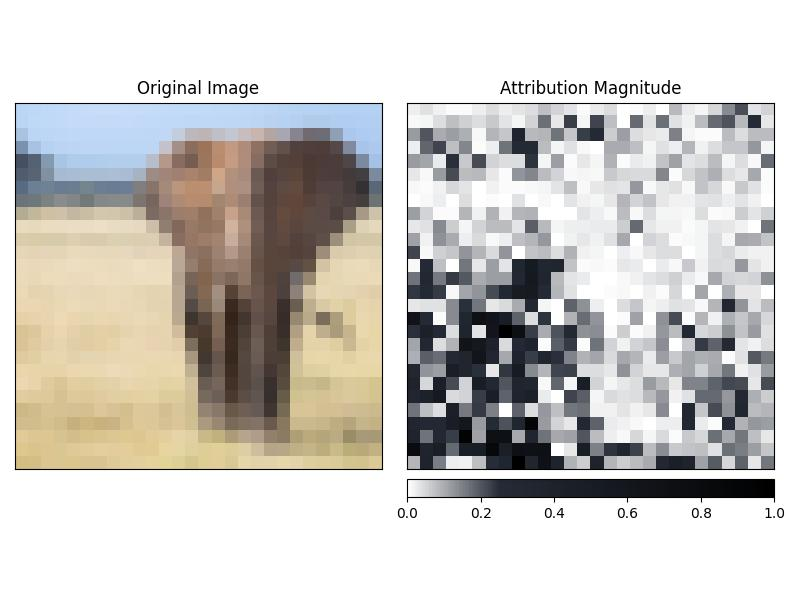

In [25]:
import IPython
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/elephant_attribution.jpg')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
young,young (0.18),stripes,37.51,how old am I?


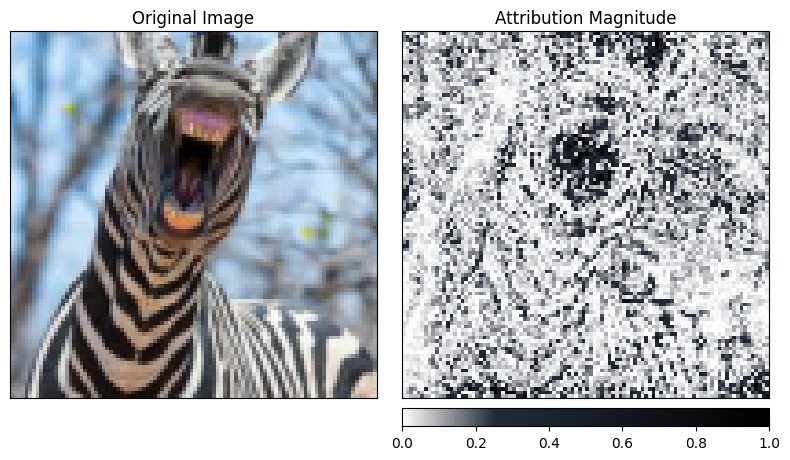

Text Contributions:  37.50645930947647
Image Contributions:  31.316538026894175
Total Contribution:  68.82299733637065


In [31]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 2 # zebra
vqa_resnet_interpret(images[image_idx], [
    "how old am I?"
], ['stripes', 'happy', 'zoo'])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
yes,yes (0.23),human,10.93,when does it sleep?


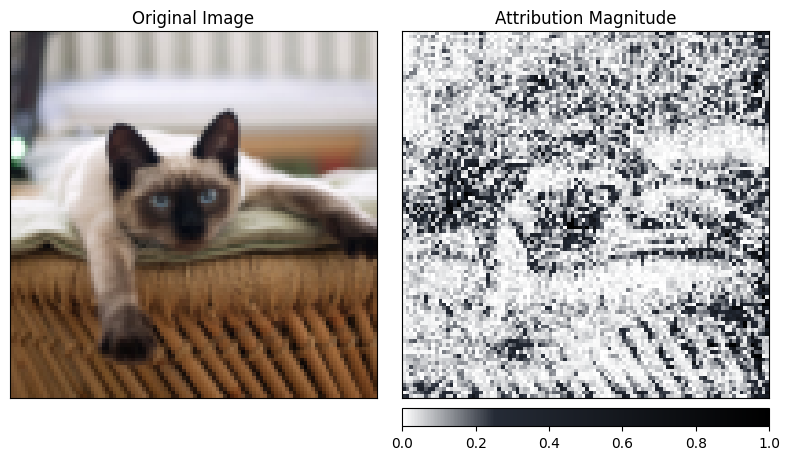

Text Contributions:  10.931150472182823
Image Contributions:  6.811144020919726
Total Contribution:  17.74229449310255


In [41]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 0 # siamese cat
vqa_resnet_interpret(images[image_idx], [
    "when does it sleep?" 
], ['human', 'stupid', 'cute'])